In [2]:
%matplotlib inline

import scipy.io
import matplotlib.pyplot as plt
import scipy
import numpy as np
import os

In [3]:
%matplotlib inline

import mpld3
mpld3.enable_notebook()

In [4]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len/2-1):-(window_len/2)]


In [5]:
from scipy.signal import argrelmax, argrelmin, find_peaks_cwt

def findLocalExtremeIndices(sig, widthPercentage = 1.0):
    peaks = find_peaks_cwt(sig, np.arange(1,len(sig)*(widthPercentage/100)))
    maximums = argrelmax(sig)[0]
    maximums = map(lambda peak: min(maximums, key=lambda x:abs(x-peak)), peaks)
    minimums = argrelmin(sig)[0]
    minimums = map(lambda peak: min(minimums, key=lambda x:abs(x-peak)), peaks)
    
    minimums = list(set(minimums))
    maximums = list(set(maximums))
    minimums.sort()
    maximums.sort()
    
    return minimums, maximums

In [6]:
mat = scipy.io.loadmat('data/Cell019-Random.mat')

In [7]:
cell = mat['Cell']

In [8]:
cell.dtype

dtype([('Analysis', 'O'), ('CellNum', 'O'), ('Th', 'O'), ('xValue', 'O'), ('vMat', 'O'), ('stimMat', 'O'), ('Headers', 'O'), ('Filename', 'O'), ('Depth', 'O'), ('WhiskerType', 'O'), ('Whisker', 'O'), ('Fs', 'O'), ('StimFs', 'O'), ('Type', 'O'), ('Intensity', 'O'), ('TrialNum', 'O'), ('xVals', 'O'), ('xValNum', 'O'), ('xValNames', 'O'), ('TraceLength', 'O'), ('fMat', 'O'), ('sMat', 'O'), ('MeanvMat', 'O'), ('MeansMat', 'O'), ('MeanfMat', 'O'), ('rawPSTH', 'O'), ('sumPSTH', 'O'), ('maxPSTH', 'O'), ('EPSPs', 'O'), ('EPSPsNorm', 'O'), ('PSTH', 'O'), ('Raster', 'O'), ('PSTHPeaks', 'O'), ('EPSPPeaks', 'O'), ('xCorrVm', 'O'), ('xCorrVmMax', 'O'), ('EPSPPeaksNorm', 'O'), ('CorrPeakVm', 'O'), ('CorrPeakVmMean', 'O'), ('CorrPeakVmSE', 'O'), ('LFPPeaks', 'O')])

In [9]:
vMat = cell['vMat'][0][0].transpose()
stimMat = cell['stimMat'][0][0].transpose()
xValuesVec = cell['xValue'][0][0].tolist()

In [10]:
'''
    xValue is a unique identifier for a stimilus pattern.
    There are 20 (as you can see below) xValues.
    Each trial was done in one of 20 stimulus patterns, and we can check which by using the xValueVec.
'''
xValues = np.unique(xValuesVec)
xValues

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [11]:
''' 
A matrix that represesnts the potential responses of the cell.
80 trials, each 40,000 samples long
vMat[i][j] := potential in sample i at trial j (mV)

40,000 samples \ 20KHz sampling rate -> trials are 2 seconds long.

thus each sample is 2 \ 40000 => 1  \ 20000 => 0.05 ms long
'''
vMat.shape

(80L, 40000L)

In [12]:
''' 
A matrix that the galvo feedback (the stimilus to the electical device 
that mechanically stimulated the whiskers.)
80 trials, each 8,000 samples long
stimMat[i][j] := ? amount of stimulus

8,000 samples \ 4KHz sampling rate -> trials are 2 seconds long.
thus each sample is 2 \ 8000 = 1 \ 4000 = 0.25ms long

'''
stimMat.shape
# Note that vMat is 5x in the X axis.
#TODO: understand how to convert between these two matrices

(80L, 8000L)

In [13]:
xValueToTrials = dict(map(lambda xValue: (xValue, [i for i in range(0,len(xValuesVec)) if xValuesVec[i] == xValue]), xValues))

In [14]:
xValueToAverageVoltagesVector = dict(map(lambda xValue: (xValue, np.mean(vMat[xValueToTrials[xValue]], axis = 0)), xValueToTrials))


In [15]:
xValueToAverageStimulusVector = dict(map(lambda xValue: (xValue, np.mean(stimMat[xValueToTrials[xValue]], axis = 0)), xValueToTrials))


In [16]:
# exampleXValue = 1

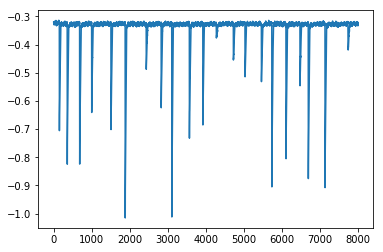

In [17]:
stimsample = xValueToAverageStimulusVector[exampleXValue]
plt.plot(stimsample)
plt.show()

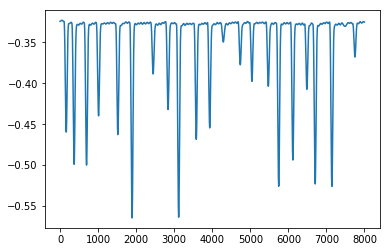

In [18]:
stimsamplesmooth = smooth(stimsample, window_len = 100,window='hanning')
plt.plot(stimsamplesmooth)
plt.show()

In [19]:
vsample = xValueToAverageVoltagesVector[exampleXValue]
plt.plot(vsample)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [20]:
vsamplesmooth = smooth(vsample, window_len = 500,window='hanning')
plt.plot(vsamplesmooth)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [21]:
from scipy.signal import argrelmax, argrelmin, find_peaks_cwt
vmin, vmax = findLocalExtremeIndices(vsamplesmooth)
vmaxMs =  [round(x*0.05,2) for x in vmax]
vminMs =  [round(x*0.05,2) for x in vmin]

vmaxMs[:8]

[49.45, 104.15, 151.7, 301.95, 388.95, 404.2, 482.2, 534.4]

In [22]:
vminMs[:8]

[29.75, 84.15, 163.7, 281.7, 371.0, 397.3, 445.1, 591.25]

In [23]:
stimmax, stimmin = findLocalExtremeIndices(stimsamplesmooth)# 2.0)
stimmaxMs =  [x*0.25 for x in stimmax]
stimminMs =  [x*0.25 for x in stimmin]

stimmaxMs[:8]

[23.0, 40.75, 92.5, 174.0, 253.0, 300.75, 362.25, 379.75]

In [24]:
stimminMs[:8]

[25.5, 58.0, 114.0, 153.25, 194.0, 234.0, 274.0, 291.0]

In [25]:
interval = 80
pairedStimulus = []

prev = stimmaxMs[0]
for cur in stimmaxMs[1:]:
    if cur - prev < interval:
        pairedStimulus += [(prev, cur)]
    prev = cur

pairedStimulus

[(23.0, 40.75),
 (40.75, 92.5),
 (174.0, 253.0),
 (253.0, 300.75),
 (300.75, 362.25),
 (362.25, 379.75),
 (473.25, 541.5),
 (541.5, 562.25),
 (562.25, 582.25),
 (582.25, 611.5),
 (611.5, 661.75),
 (661.75, 709.5),
 (709.5, 762.0),
 (762.0, 779.25),
 (863.0, 895.0),
 (895.0, 961.0),
 (961.0, 983.5),
 (983.5, 1042.5),
 (1042.5, 1072.5),
 (1072.5, 1122.0),
 (1122.0, 1184.0),
 (1184.0, 1241.5),
 (1241.5, 1260.75),
 (1260.75, 1320.5),
 (1320.5, 1368.25),
 (1368.25, 1420.75),
 (1420.75, 1436.75),
 (1436.75, 1481.5),
 (1481.5, 1529.75),
 (1529.75, 1601.75),
 (1601.75, 1621.75),
 (1621.75, 1676.25),
 (1676.25, 1720.75),
 (1720.75, 1740.5),
 (1740.5, 1786.0),
 (1786.0, 1841.25),
 (1841.25, 1901.0),
 (1901.0, 1920.25),
 (1920.25, 1937.75),
 (1937.75, 1981.75)]

In [26]:
pairingRation = 1.5
#TODO: account for the variying amplitude of the stimulus? 


In [27]:
#TODO find spikes by a sequence of min - max - min ?
# Then find the correspondant spike ?
# then try and find paired-pulses and thier influence





In [28]:
cell['MeansMat'][0][0].transpose()[1]

array([-0.53918151,  0.02458894,  0.17484615, ...,  0.92960819,
        0.87608628,  0.6707394 ])

In [29]:
xValueToAverageVoltagesVector[1]

array([-86.29989624, -86.89498901, -86.65466309, ..., -89.02740479,
       -88.90914917, -88.87481689])

In [30]:
cell['Type'][0][0]

array([[array([u'Intra'],
      dtype='<U5')]], dtype=object)